In [ ]:
"""Refactor del flujo de evaluación de prolapsos.

1. ``build_data_store``: carga y organiza *todos* los datos (splits y modelos) en un
   único diccionario anidado.
2. ``evaluate_data_store``: calcula todas las métricas (a nivel de fila y a nivel
   de caso) a partir del diccionario de datos y devuelve los resultados en otro
   diccionario.

Ejemplo de uso
--------------

>>> prolapses = ["any_prolapse"]
>>> data_store = build_data_store(prolapses)
>>> results = evaluate_data_store(data_store)
>>> results["any_prolapse"]["fila"]["df"].head()
>>> results["any_prolapse"]["case"]["best_models"][0.5]
"""
from __future__ import annotations

import os
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import numpy as np
import pandas as pd
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

BASE_DIR: Path = Path.cwd().parent.parent
MODELS: List[str] = ["dt", "knn", "lr", "rf", "Xgboost"]
THRESHOLDS: List[Tuple[float, str]] = [(0.5, ""), (0.6, "_60")]


def safe_metric(func, y_true, y_score):
    """Envuelve métricas susceptibles de fallo cuando *y_true* tiene una sola clase."""
    try:
        return func(y_true, y_score)
    except ValueError:
        warnings.warn(
            f"{func.__name__} indefinida (solo se encontró una clase en y_true)",
            UndefinedMetricWarning,
        )
        return np.nan


def aggregate_predictions(
    df_test: pd.DataFrame,
    y_true: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    *,
    case_col: str = "video",
    threshold: float = 0.5,
):
    """Agrega predicciones frame → caso usando la media de probabilidades."""
    df_pred = df_test[[case_col]].copy()
    df_pred["true"] = y_true
    df_pred["proba"] = y_proba

    agg = df_pred.groupby(case_col).agg(
        proba=("proba", "mean"),
        true=("true", "first"),
    )

    agg["pred"] = (agg["proba"] >= threshold).astype(int)
    return agg["true"], agg["pred"], agg["proba"]


def select_best_model(df: pd.DataFrame) -> pd.Series:
    """Selecciona el mejor modelo según (1) AUC, (2) AP, (3) accuracy, (4) F1."""
    criterios = ["auc", "average_precision", "accuracy", "f1_weighted"]
    return df.sort_values(by=criterios, ascending=False).iloc[0]


def _collect_prolapse_data(
    prolapse: str,
    *,
    models: List[str] = MODELS,
    thresholds: List[Tuple[float, str]] = THRESHOLDS,
    base_dir: Path = BASE_DIR,
):
    """Carga *df_test* y los modelos entrenados para un prolapso concreto."""
    data: Dict[str, dict] = {}

    for umbral, sufijo in thresholds:
        test_path = base_dir / "data_storage" / "train_test_splits" / prolapse / f"train_test_split{sufijo}.pkl"
        if not test_path.exists():
            warnings.warn(f"❌ No se encontró el split: {test_path}")
            continue

        df_train, df_test = joblib.load(test_path)
        X_test = df_test.drop(columns=[prolapse, "frame_start", "frame_end"])
        y_test = df_test[prolapse]

        model_dict: Dict[str, object] = {}
        for model in models:
            model_path = base_dir / "data_storage" / "models" / prolapse / model / f"best_model{sufijo}.pkl"
            if not model_path.exists():
                warnings.warn(f"⚠️ Falta el modelo: {model_path}")
                continue
            model_dict[model] = joblib.load(model_path)

        if model_dict: 
            data[sufijo] = {
                "umbral": umbral,
                "df_test": df_test,
                "X_test": X_test,
                "y_test": y_test,
                "models": model_dict,
            }

    return data


def build_data_store(
    prolapses: List[str],
    *,
    models: List[str] = MODELS,
    thresholds: List[Tuple[float, str]] = THRESHOLDS,
    base_dir: Path = BASE_DIR,
):
    """Devuelve un diccionario anidado con *todos* los datos necesarios.

    Estructura::

        data_store[prolapse][sufijo] = {
            "umbral": float,
            "df_test": pd.DataFrame,
            "X_test": pd.DataFrame,
            "y_test": pd.Series,
            "models": {model_name: sklearn.BaseEstimator, ...},
        }
    """
    return {
        prolapse: _collect_prolapse_data(
            prolapse,
            models=models,
            thresholds=thresholds,
            base_dir=base_dir,
        )
        for prolapse in prolapses
    }


def evaluate_data_store(data_store: dict):
    """Calcula todas las métricas de evaluación y devuelve otro diccionario.

    Estructura del resultado::

        results[prolapse] = {
            "fila": {
                "df": pd.DataFrame,
                "best_models": {umbral: pd.Series},
            },
            "case": {
                "df": pd.DataFrame,
                "best_models": {umbral: pd.Series},
            },
        }
    """
    results: Dict[str, dict] = {}

    for prolapse, thresh_data in data_store.items():
        fila_rows: List[dict] = []
        case_rows: List[dict] = []

        for sufijo, items in thresh_data.items():
            umbral = items["umbral"]
            df_test = items["df_test"]
            X_test = items["X_test"]
            y_test = items["y_test"]

            for model_name, clf in items["models"].items():
                if hasattr(clf, "feature_names_in_"):
                    valid_features = [f for f in clf.feature_names_in_ if f in X_test.columns]
                    X_test_mod = X_test[valid_features]
                else:
                    X_test_mod = X_test

                y_pred = clf.predict(X_test_mod)
                y_proba = clf.predict_proba(X_test_mod)[:, 1]
                fila_rows.append(
                    {
                        "prolapse": prolapse,
                        "modelo": model_name,
                        "umbral": umbral,
                        "accuracy": accuracy_score(y_test, y_pred),
                        "auc": safe_metric(roc_auc_score, y_test, y_proba),
                        "average_precision": safe_metric(average_precision_score, y_test, y_proba),
                        "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                        "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                        "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
                        "precision_pos": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
                        "recall_pos": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
                        "f1_pos": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
                    }
                )

                y_true_case, y_pred_case, y_proba_case = aggregate_predictions(
                    df_test,
                    y_test,
                    y_pred,
                    y_proba,
                    case_col="video",
                    threshold=umbral,
                )

                case_rows.append(
                    {
                        "prolapse": prolapse,
                        "modelo": model_name,
                        "umbral": umbral,
                        "accuracy": accuracy_score(y_true_case, y_pred_case),
                        "auc": safe_metric(roc_auc_score, y_true_case, y_proba_case),
                        "average_precision": safe_metric(average_precision_score, y_true_case, y_proba_case),
                        "precision_weighted": precision_score(y_true_case, y_pred_case, average="weighted", zero_division=0),
                        "recall_weighted": recall_score(y_true_case, y_pred_case, average="weighted", zero_division=0),
                        "f1_weighted": f1_score(y_true_case, y_pred_case, average="weighted", zero_division=0),
                        "precision_pos": precision_score(y_true_case, y_pred_case, pos_label=1, zero_division=0),
                        "recall_pos": recall_score(y_true_case, y_pred_case, pos_label=1, zero_division=0),
                        "f1_pos": f1_score(y_true_case, y_pred_case, pos_label=1, zero_division=0),
                    }
                )

        df_fila = pd.DataFrame(fila_rows)
        df_case = pd.DataFrame(case_rows)

        best_models_fila = {u: select_best_model(df_fila[df_fila["umbral"] == u]) for u in df_fila["umbral"].unique()}
        best_models_case = {u: select_best_model(df_case[df_case["umbral"] == u]) for u in df_case["umbral"].unique()}

        results[prolapse] = {
            "fila": {"df": df_fila, "best_models": best_models_fila},
            "case": {"df": df_case, "best_models": best_models_case},
        }

    return results

from __future__ import annotations

"""Ajuste de umbral por CV y evaluación en test
================================================

Función principal
-----------------

>>> ajustar_y_evaluar_prolapse(
...     prolapse="any_prolapse",
...     modelo="rf",
...     precision_target=0.72,
...     recall_target=0.95,
...     sufijo="",              # "" → τ_s=0.5, "_60" → τ_s=0.6, ...
... )

El flujo realiza:
1. Carga los *splits* y el modelo desde la estructura ``data_storage``.
2. Ajusta un **umbral óptimo** sobre *train* (cross-val. estratificada por vídeo).
3. Dibuja la curva *Precision–Recall* y marca el punto seleccionado.
4. Evalúa el modelo en *test* a nivel **de caso** usando ese umbral.
5. Muestra/salva la matriz de confusión y las métricas principales.

Devuelve ``umbral_opt`` y ``metrics_case`` para uso posterior.
"""

from pathlib import Path
from typing import Tuple, Dict
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)

__all__ = ["ajustar_y_evaluar_prolapse"]


# -----------------------------------------------------------------------------
# Utilidades
# -----------------------------------------------------------------------------

def _safe_metric(func, y_true, y_score):
    """Evita fallos cuando *y_true* tiene una sola clase."""
    try:
        return func(y_true, y_score)
    except ValueError:
        warnings.warn(
            f"{func.__name__} indefinida (solo una clase en y_true)",
            RuntimeWarning,
            stacklevel=2,
        )
        return np.nan


# -----------------------------------------------------------------------------
# Función principal
# -----------------------------------------------------------------------------

from pathlib import Path
from typing import Tuple, Dict
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)

__all__ = ["ajustar_y_evaluar_prolapse"]


# --------------------------------------------------------------------------
# Utilidad para métricas “seguras”
# --------------------------------------------------------------------------
def _safe_metric(func, y_true, y_score):
    try:
        return func(y_true, y_score)
    except ValueError:
        warnings.warn(
            f"{func.__name__} indefinida (solo una clase en y_true)",
            RuntimeWarning,
            stacklevel=2,
        )
        return np.nan


# --------------------------------------------------------------------------
# Función principal
# --------------------------------------------------------------------------
def ajustar_y_evaluar_prolapse(
    prolapse: str,
    modelo: str,
    *,
    precision_target: float = 0.7,
    recall_target: float = 0.9,
    sufijo: str = "",
    case_col: str = "video",
    agg_func: str = "mean",
    n_splits: int = 5,
    base_dir: Path | str = Path.cwd().parent.parent,
    guardar: bool = True,
    show: bool = True,
) -> Tuple[float | None, Dict[str, float]]:
    """
    Ajusta un umbral que cumpla (precision, recall) y evalúa en *test* (nivel caso).
    """

    base_dir = Path(base_dir)
    reports_dir = base_dir / "reports"
    reports_dir.mkdir(parents=True, exist_ok=True)

    # ------------------------------------------------------------------
    # 1. Carga datos y modelo
    # ------------------------------------------------------------------
    split_path = (
        base_dir
        / "data_storage"
        / "train_test_splits"
        / prolapse
        / f"train_test_split{sufijo}.pkl"
    )
    model_path = (
        base_dir
        / "data_storage"
        / "models"
        / prolapse
        / modelo
        / f"best_model{sufijo}.pkl"
    )

    if not split_path.exists():
        raise FileNotFoundError(f"❌ No se encontró el split: {split_path}")
    if not model_path.exists():
        raise FileNotFoundError(f"❌ No se encontró el modelo: {model_path}")

    df_train, df_test = joblib.load(split_path)
    clf = joblib.load(model_path)

    # ------------------------------------------------------------------
    # 🔹 Forzamos reproducibilidad en XGBoost ---------------------------
    # ------------------------------------------------------------------
    if modelo.lower() == "xgboost":
        # Si los parámetros existen, se fijan a 42
        for param in ("random_state", "seed"):
            if param in clf.get_params():
                clf.set_params(**{param: 42})
        # También fijamos la semilla global de NumPy
        np.random.seed(42)

    # ------------------------------------------------------------------
    # 2. Probabilidades CV en *train*
    # ------------------------------------------------------------------
    X_train = df_train.drop(columns=[prolapse, "frame_start", "frame_end"], errors="ignore")
    y_train = df_train[prolapse]
    groups_train = df_train[case_col]

    if hasattr(clf, "feature_names_in_"):
        valid_features = [f for f in clf.feature_names_in_ if f in X_train.columns]
        X_train = X_train[valid_features]

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_proba_train = cross_val_predict(
        clf,
        X_train,
        y_train,
        groups=groups_train,
        cv=sgkf,
        method="predict_proba",
        n_jobs=-1,
    )[:, 1]

    df_pred_train = df_train[[case_col]].copy()
    df_pred_train["true"] = y_train
    df_pred_train["proba"] = y_proba_train

    agg_train = (
        df_pred_train.groupby(case_col)
        .agg(proba=("proba", agg_func), true=("true", "max"))
        .reset_index()
    )

    # ------------------------------------------------------------------
    # 3. Selección de umbral en *train*
    # ------------------------------------------------------------------
    precision, recall, thresholds = precision_recall_curve(
        agg_train["true"], agg_train["proba"]
    )
    precision_adj, recall_adj = precision[1:], recall[1:]

    idx_valid = np.where(
        (precision_adj >= precision_target) & (recall_adj >= recall_target)
    )[0]
    if idx_valid.size:
        idx_opt = idx_valid[0]
        umbral_opt = float(thresholds[idx_opt])
    else:
        # Fallback: maximizar F1
        f1s = (2 * precision_adj * recall_adj) / (precision_adj + recall_adj + 1e-12)
        idx_opt = int(f1s.argmax())
        umbral_opt = float(thresholds[idx_opt])
        warnings.warn(
            "No se alcanzaron los objetivos → se usa el umbral con F1 máximo.",
            RuntimeWarning,
            stacklevel=2,
        )

    # ------------------------------------------------------------------
    # 4. Curva Precision–Recall
    # ------------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".")
    plt.scatter(recall_adj[idx_opt], precision_adj[idx_opt], color="red")
    plt.text(
        recall_adj[idx_opt],
        precision_adj[idx_opt],
        f" Th={umbral_opt:.3f}",
        color="red",
        va="bottom",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva PR – {prolapse} ({modelo})")
    plt.grid(True)
    if guardar:
        pr_path = reports_dir / f"pr_curve_{prolapse}_{modelo}{sufijo}.png"
        plt.savefig(pr_path, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    # ------------------------------------------------------------------
    # 5. Evaluación en *test*
    # ------------------------------------------------------------------
    X_test = df_test.drop(columns=[prolapse, "frame_start", "frame_end"], errors="ignore")
    y_test = df_test[prolapse]
    if hasattr(clf, "feature_names_in_"):
        valid_features = [f for f in clf.feature_names_in_ if f in X_test.columns]
        X_test = X_test[valid_features]

    y_proba_test = clf.predict_proba(X_test)[:, 1]

    df_pred_test = df_test[[case_col]].copy()
    df_pred_test["true"] = y_test
    df_pred_test["proba"] = y_proba_test

    agg_test = df_pred_test.groupby(case_col).agg(
        proba=("proba", agg_func),
        true=("true", "max"),
    )
    agg_test["pred"] = (agg_test["proba"] >= umbral_opt).astype(int)

    y_true_case = agg_test["true"]
    y_pred_case = agg_test["pred"]
    y_score_case = agg_test["proba"]

    metrics_case = {
        "accuracy": accuracy_score(y_true_case, y_pred_case),
        "auc": _safe_metric(roc_auc_score, y_true_case, y_score_case),
        "average_precision": _safe_metric(
            average_precision_score, y_true_case, y_score_case
        ),
        "precision_weighted": precision_score(
            y_true_case, y_pred_case, average="weighted", zero_division=0
        ),
        "recall_weighted": recall_score(
            y_true_case, y_pred_case, average="weighted", zero_division=0
        ),
        "f1_weighted": f1_score(
            y_true_case, y_pred_case, average="weighted", zero_division=0
        ),
        "precision_pos": precision_score(
            y_true_case, y_pred_case, pos_label=1, zero_division=0
        ),
        "recall_pos": recall_score(
            y_true_case, y_pred_case, pos_label=1, zero_division=0
        ),
        "f1_pos": f1_score(y_true_case, y_pred_case, pos_label=1, zero_division=0),
    }

    # ------------------------------------------------------------------
    # 6. Matriz de confusión
    # ------------------------------------------------------------------
    cm = confusion_matrix(y_true_case, y_pred_case)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negativo", "Positivo"],
        yticklabels=["Negativo", "Positivo"],
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión (por caso)")
    plt.tight_layout()
    if guardar:
        cm_path = reports_dir / f"confusion_matrix_{prolapse}_{modelo}{sufijo}.png"
        plt.savefig(cm_path, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    # ------------------------------------------------------------------
    # 7. Resumen por consola
    # ------------------------------------------------------------------
    print(f"\n✅ Umbral óptimo: {umbral_opt:.4f}")
    print("\n📊 Métricas a nivel de caso:")
    for k, v in metrics_case.items():
        print(f"{k:<18}: {v:.4f}")

    return umbral_opt, metrics_case



<>:332: SyntaxWarning: invalid escape sequence '\*'
<>:332: SyntaxWarning: invalid escape sequence '\*'
C:\Users\javie\AppData\Local\Temp\ipykernel_13484\2725897316.py:332: SyntaxWarning: invalid escape sequence '\*'
  """Ajusta un umbral que cumpla (\*precision\*, \*recall\*) y evalúa en *test*.


In [89]:
def evaluate_prolapse(prolapse: str):
    """Devuelve DataFrame de resultados *a nivel de caso* y el mejor modelo global.

    Criterio del mejor modelo → ``select_best_model``.
    """
    data    = build_data_store([prolapse])
    results = evaluate_data_store(data)
    df_case = results[prolapse]["case"]["df"].copy()

    best_model = select_best_model(df_case)
    return {"df": df_case, "best_model": best_model}

In [90]:
evaluate_prolapse("any_prolapse")["df"]

,prolapse,modelo,umbral,accuracy,auc,average_precision,precision_weighted,recall_weighted,f1_weighted,precision_pos,recall_pos,f1_pos
0,any_prolapse,dt,0.5,0.974359,1.000000,1.000000,0.975580,0.974359,0.974325,0.952381,1.00,0.975610
1,any_prolapse,knn,0.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000
2,any_prolapse,lr,0.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000
3,any_prolapse,rf,0.5,0.974359,1.000000,1.000000,0.975580,0.974359,0.974325,0.952381,1.00,0.975610
4,any_prolapse,Xgboost,0.5,0.974359,1.000000,1.000000,0.975580,0.974359,0.974325,0.952381,1.00,0.975610
5,any_prolapse,dt,0.6,0.948718,0.994737,0.995455,0.948718,0.948718,0.948718,0.950000,0.95,0.950000
6,any_prolapse,knn,0.6,0.948718,1.000000,1.000000,0.953602,0.948718,0.948650,1.000000,0.90,0.947368
7,any_prolapse,lr,0.6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000
8,any_prolapse,rf,0.6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000
9,any_prolapse,Xgboost,0.6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000


In [91]:
evaluate_prolapse("any_prolapse")["best_model"]

prolapse              any_prolapse
modelo                         knn
umbral                         0.5
accuracy                       1.0
auc                            1.0
average_precision              1.0
precision_weighted             1.0
recall_weighted                1.0
f1_weighted                    1.0
precision_pos                  1.0
recall_pos                     1.0
f1_pos                         1.0
Name: 1, dtype: object

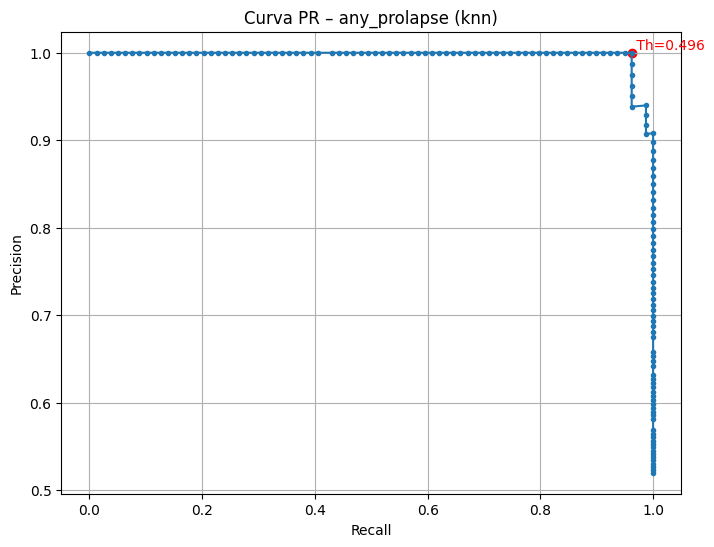

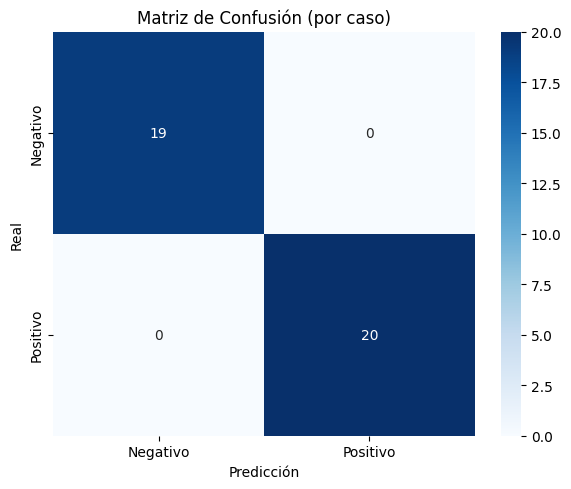


✅ Umbral óptimo: 0.4963

📊 Métricas a nivel de caso:
accuracy          : 1.0000
auc               : 1.0000
average_precision : 1.0000
precision_weighted: 1.0000
recall_weighted   : 1.0000
f1_weighted       : 1.0000
precision_pos     : 1.0000
recall_pos        : 1.0000
f1_pos            : 1.0000


In [92]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="any_prolapse",
    modelo="knn",
    precision_target=1.0,
    recall_target=0.96, 
    sufijo="", 
    n_splits=5, 
    guardar=True,          
    show=True,              
)

evaluate_prolapse("cervical_elongation")["df"]

In [93]:
evaluate_prolapse("cervical_elongation")["best_model"]

prolapse              cervical_elongation
modelo                            Xgboost
umbral                                0.5
accuracy                         0.974359
auc                                   1.0
average_precision                     1.0
precision_weighted               0.977564
recall_weighted                  0.974359
f1_weighted                       0.97501
precision_pos                       0.875
recall_pos                            1.0
f1_pos                           0.933333
Name: 4, dtype: object

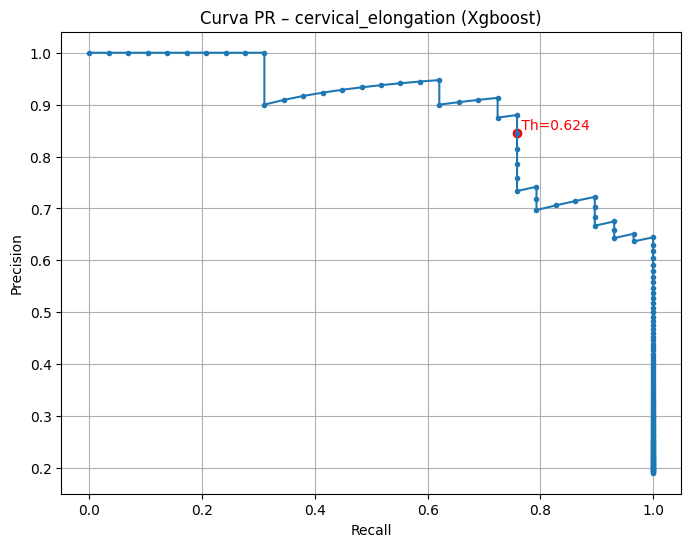

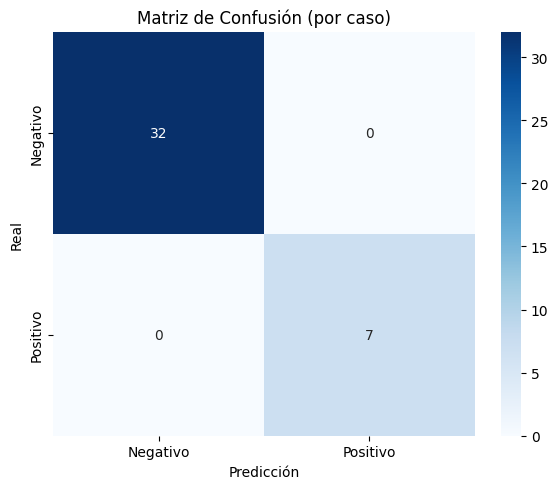


✅ Umbral óptimo: 0.6239

📊 Métricas a nivel de caso:
accuracy          : 1.0000
auc               : 1.0000
average_precision : 1.0000
precision_weighted: 1.0000
recall_weighted   : 1.0000
f1_weighted       : 1.0000
precision_pos     : 1.0000
recall_pos        : 1.0000
f1_pos            : 1.0000


In [101]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="cervical_elongation",
    modelo="Xgboost",
    precision_target=0.84,
    recall_target=0.74,
    sufijo="",
    n_splits=5,
    guardar=True,
    show=True,
)

In [52]:
evaluate_prolapse("cystocele")["df"]

,prolapse,modelo,umbral,accuracy,auc,average_precision,precision_weighted,recall_weighted,f1_weighted,precision_pos,recall_pos,f1_pos
0,cystocele,dt,0.5,0.897436,0.971429,0.949366,0.920228,0.897436,0.899387,0.777778,1.000000,0.875000
1,cystocele,knn,0.5,0.897436,0.960000,0.931667,0.904822,0.897436,0.898718,0.812500,0.928571,0.866667
2,cystocele,lr,0.5,0.897436,0.977143,0.962395,0.920228,0.897436,0.899387,0.777778,1.000000,0.875000
3,cystocele,rf,0.5,0.948718,0.962857,0.928311,0.955128,0.948718,0.949359,0.875000,1.000000,0.933333
4,cystocele,Xgboost,0.5,0.948718,0.982857,0.970559,0.955128,0.948718,0.949359,0.875000,1.000000,0.933333
5,cystocele,dt,0.6,0.897436,0.968571,0.940935,0.898860,0.897436,0.895464,0.916667,0.785714,0.846154
6,cystocele,knn,0.6,0.820513,0.957143,0.923858,0.859776,0.820513,0.801619,1.000000,0.500000,0.666667
7,cystocele,lr,0.6,0.820513,0.905714,0.776782,0.818540,0.820513,0.818949,0.769231,0.714286,0.740741
8,cystocele,rf,0.6,0.820513,0.957143,0.909179,0.820263,0.820513,0.814823,0.818182,0.642857,0.720000
9,cystocele,Xgboost,0.6,0.897436,0.954286,0.903343,0.897436,0.897436,0.897436,0.857143,0.857143,0.857143


In [53]:
evaluate_prolapse("cystocele")["best_model"]

prolapse              cystocele
modelo                  Xgboost
umbral                      0.5
accuracy               0.948718
auc                    0.982857
average_precision      0.970559
precision_weighted     0.955128
recall_weighted        0.948718
f1_weighted            0.949359
precision_pos             0.875
recall_pos                  1.0
f1_pos                 0.933333
Name: 4, dtype: object

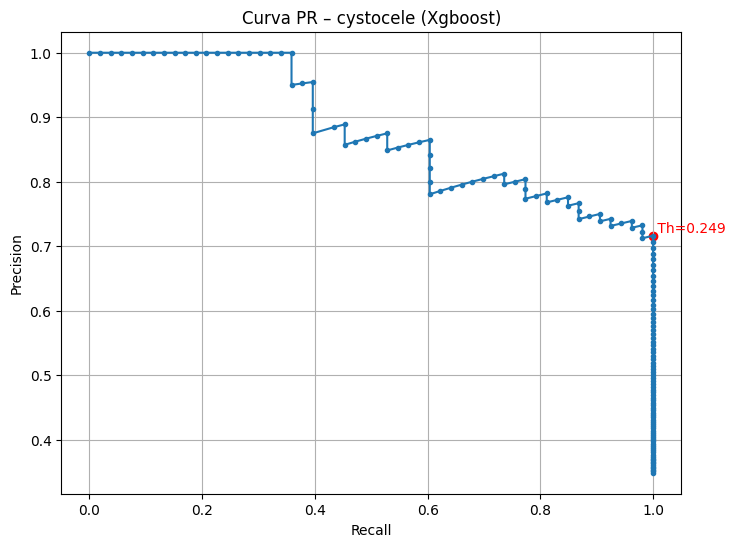

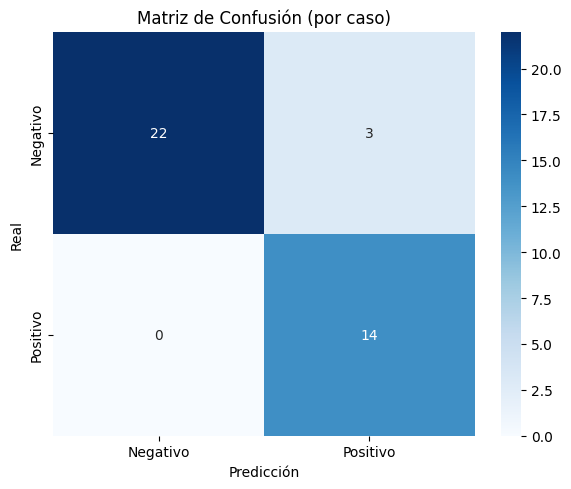


✅ Umbral óptimo: 0.2486

📊 Métricas a nivel de caso:
accuracy          : 0.9231
auc               : 0.9829
average_precision : 0.9706
precision_weighted: 0.9367
recall_weighted   : 0.9231
f1_weighted       : 0.9243
precision_pos     : 0.8235
recall_pos        : 1.0000
f1_pos            : 0.9032


In [99]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="cystocele",
    modelo="Xgboost",
    precision_target=0.715,
    recall_target=1,
    sufijo="",
    n_splits=5,
    guardar=True,
    show=True,
)

In [54]:
evaluate_prolapse("cystourethrocele")["df"]

,prolapse,modelo,umbral,accuracy,auc,average_precision,precision_weighted,recall_weighted,f1_weighted,precision_pos,recall_pos,f1_pos
0,cystourethrocele,dt,0.5,0.923077,0.736111,0.454212,0.852071,0.923077,0.886154,0.0,0.000000,0.0
1,cystourethrocele,knn,0.5,0.948718,0.898148,0.583333,0.951417,0.948718,0.936590,1.0,0.333333,0.5
2,cystourethrocele,lr,0.5,0.923077,0.833333,0.478836,0.852071,0.923077,0.886154,0.0,0.000000,0.0
3,cystourethrocele,rf,0.5,0.923077,0.861111,0.500000,0.852071,0.923077,0.886154,0.0,0.000000,0.0
4,cystourethrocele,Xgboost,0.5,0.948718,0.851852,0.500000,0.951417,0.948718,0.936590,1.0,0.333333,0.5
5,cystourethrocele,dt,0.6,0.923077,0.680556,0.410256,0.852071,0.923077,0.886154,0.0,0.000000,0.0
6,cystourethrocele,knn,0.6,0.948718,0.879630,0.543590,0.951417,0.948718,0.936590,1.0,0.333333,0.5
7,cystourethrocele,lr,0.6,0.923077,0.824074,0.479167,0.852071,0.923077,0.886154,0.0,0.000000,0.0
8,cystourethrocele,rf,0.6,0.923077,0.861111,0.505495,0.852071,0.923077,0.886154,0.0,0.000000,0.0
9,cystourethrocele,Xgboost,0.6,0.948718,0.842593,0.488095,0.951417,0.948718,0.936590,1.0,0.333333,0.5


In [55]:
evaluate_prolapse("cystourethrocele")["best_model"]

prolapse              cystourethrocele
modelo                             knn
umbral                             0.5
accuracy                      0.948718
auc                           0.898148
average_precision             0.583333
precision_weighted            0.951417
recall_weighted               0.948718
f1_weighted                    0.93659
precision_pos                      1.0
recall_pos                    0.333333
f1_pos                             0.5
Name: 1, dtype: object

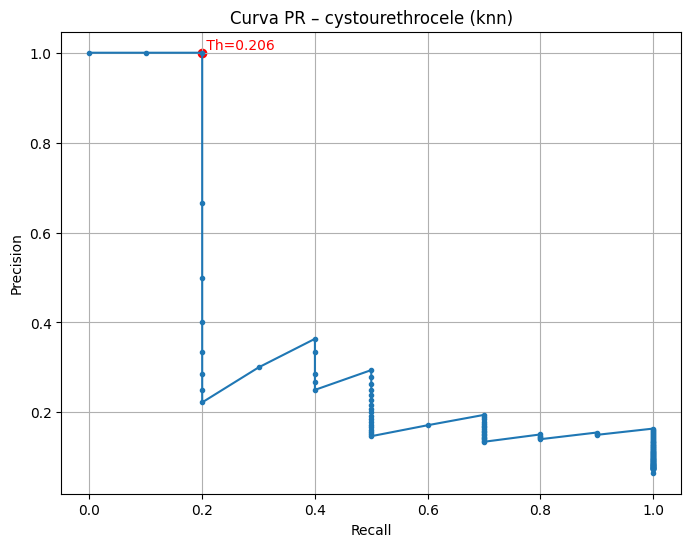

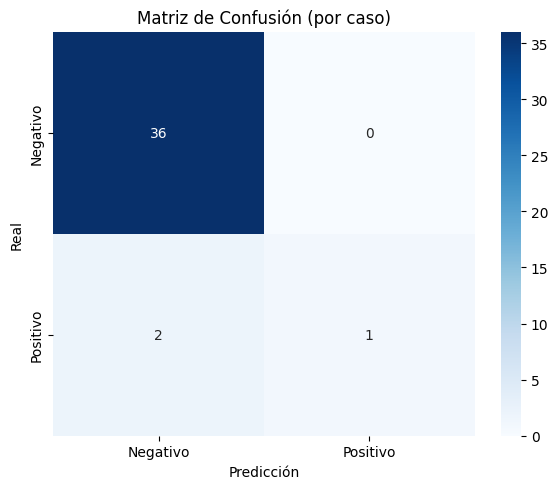


✅ Umbral óptimo: 0.2056

📊 Métricas a nivel de caso:
accuracy          : 0.9487
auc               : 0.8981
average_precision : 0.5833
precision_weighted: 0.9514
recall_weighted   : 0.9487
f1_weighted       : 0.9366
precision_pos     : 1.0000
recall_pos        : 0.3333
f1_pos            : 0.5000


In [84]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="cystourethrocele",
    modelo="knn",
    precision_target=1,
    recall_target=0.2,
    sufijo="",
    n_splits=5,
    guardar=True,
    show=True,
)

In [56]:
evaluate_prolapse("rectocele")["df"]

,prolapse,modelo,umbral,accuracy,auc,average_precision,precision_weighted,recall_weighted,f1_weighted,precision_pos,recall_pos,f1_pos
0,rectocele,dt,0.5,0.923077,0.664706,0.494139,0.929314,0.923077,0.908219,1.000000,0.4,0.571429
1,rectocele,knn,0.5,0.897436,0.876471,0.571429,0.908232,0.897436,0.866097,1.000000,0.2,0.333333
2,rectocele,lr,0.5,0.897436,0.876471,0.581046,0.884615,0.897436,0.886081,0.666667,0.4,0.500000
3,rectocele,rf,0.5,0.897436,0.941176,0.755195,0.908232,0.897436,0.866097,1.000000,0.2,0.333333
4,rectocele,Xgboost,0.5,0.923077,0.776471,0.542857,0.929314,0.923077,0.908219,1.000000,0.4,0.571429
5,rectocele,dt,0.6,0.871795,0.735294,0.541188,0.760026,0.871795,0.812083,0.000000,0.0,0.000000
6,rectocele,knn,0.6,0.897436,0.900000,0.693109,0.908232,0.897436,0.866097,1.000000,0.2,0.333333
7,rectocele,lr,0.6,0.871795,0.629412,0.310022,0.760026,0.871795,0.812083,0.000000,0.0,0.000000
8,rectocele,rf,0.6,0.871795,0.917647,0.815556,0.760026,0.871795,0.812083,0.000000,0.0,0.000000
9,rectocele,Xgboost,0.6,0.923077,0.747059,0.549401,0.929314,0.923077,0.908219,1.000000,0.4,0.571429


In [57]:
evaluate_prolapse("rectocele")["best_model"]

prolapse              rectocele
modelo                       rf
umbral                      0.5
accuracy               0.897436
auc                    0.941176
average_precision      0.755195
precision_weighted     0.908232
recall_weighted        0.897436
f1_weighted            0.866097
precision_pos               1.0
recall_pos                  0.2
f1_pos                 0.333333
Name: 3, dtype: object

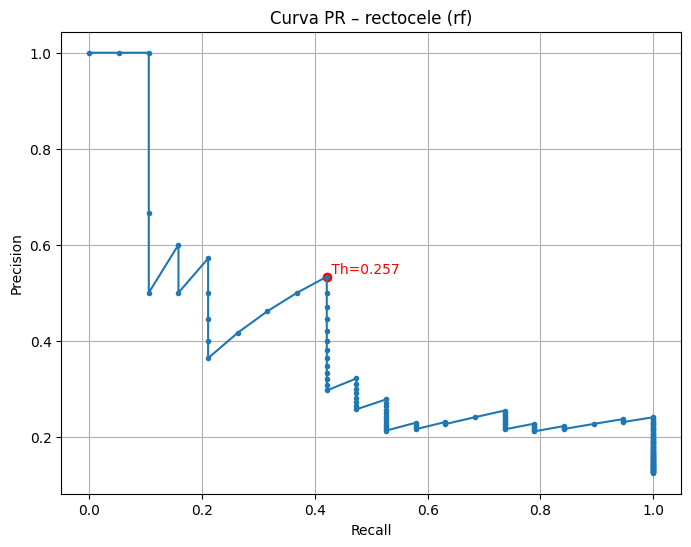

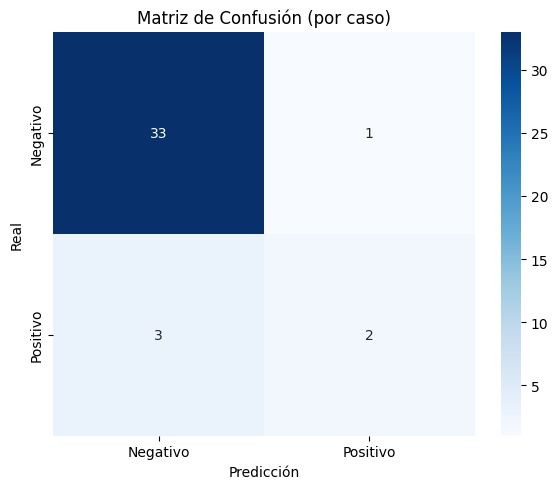


✅ Umbral óptimo: 0.2568

📊 Métricas a nivel de caso:
accuracy          : 0.8974
auc               : 0.9412
average_precision : 0.7552
precision_weighted: 0.8846
recall_weighted   : 0.8974
f1_weighted       : 0.8861
precision_pos     : 0.6667
recall_pos        : 0.4000
f1_pos            : 0.5000


In [85]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="rectocele",
    modelo="rf",
    precision_target=0.53,
    recall_target=0.4,
    sufijo="",
    n_splits=5,
    guardar=True,
    show=True,
)

In [58]:
evaluate_prolapse("uterine_prolapse")["df"]

,prolapse,modelo,umbral,accuracy,auc,average_precision,precision_weighted,recall_weighted,f1_weighted,precision_pos,recall_pos,f1_pos
0,uterine_prolapse,dt,0.5,0.923077,0.943548,0.747222,0.927920,0.923077,0.924709,0.777778,0.875,0.823529
1,uterine_prolapse,knn,0.5,0.897436,0.971774,0.910552,0.909158,0.897436,0.883450,1.000000,0.500,0.666667
2,uterine_prolapse,lr,0.5,0.948718,0.975806,0.924851,0.948718,0.948718,0.948718,0.875000,0.875,0.875000
3,uterine_prolapse,rf,0.5,0.897436,0.979839,0.920685,0.893551,0.897436,0.891712,0.833333,0.625,0.714286
4,uterine_prolapse,Xgboost,0.5,0.948718,0.975806,0.911594,0.948718,0.948718,0.948718,0.875000,0.875,0.875000
5,uterine_prolapse,dt,0.6,0.820513,0.967742,0.852282,0.853576,0.820513,0.759817,1.000000,0.125,0.222222
6,uterine_prolapse,knn,0.6,0.846154,0.979839,0.938131,0.871102,0.846154,0.806787,1.000000,0.250,0.400000
7,uterine_prolapse,lr,0.6,0.846154,0.975806,0.875546,0.871102,0.846154,0.806787,1.000000,0.250,0.400000
8,uterine_prolapse,rf,0.6,0.897436,0.975806,0.908532,0.909158,0.897436,0.883450,1.000000,0.500,0.666667
9,uterine_prolapse,Xgboost,0.6,0.871795,0.979839,0.920685,0.865460,0.871795,0.859961,0.800000,0.500,0.615385


In [59]:
evaluate_prolapse("uterine_prolapse")["best_model"]

prolapse              uterine_prolapse
modelo                              rf
umbral                             0.5
accuracy                      0.897436
auc                           0.979839
average_precision             0.920685
precision_weighted            0.893551
recall_weighted               0.897436
f1_weighted                   0.891712
precision_pos                 0.833333
recall_pos                       0.625
f1_pos                        0.714286
Name: 3, dtype: object

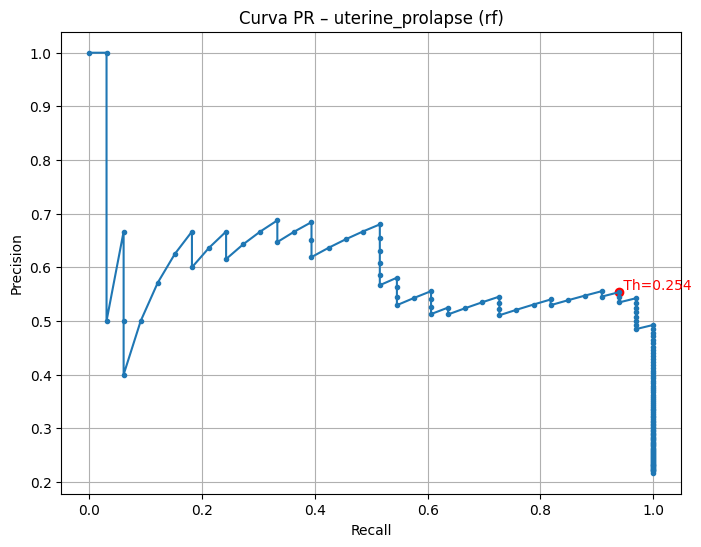

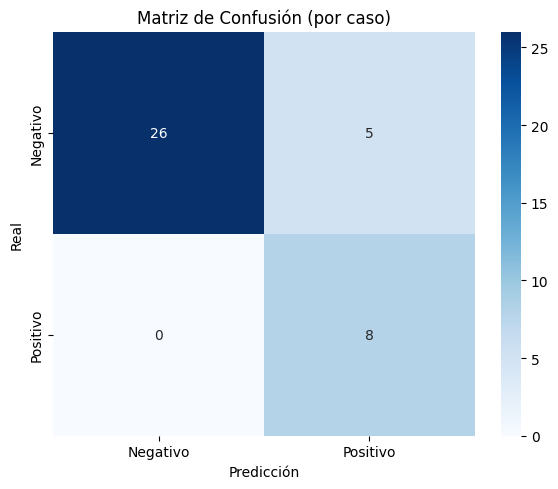


✅ Umbral óptimo: 0.2543

📊 Métricas a nivel de caso:
accuracy          : 0.8718
auc               : 0.9798
average_precision : 0.9207
precision_weighted: 0.9211
recall_weighted   : 0.8718
f1_weighted       : 0.8814
precision_pos     : 0.6154
recall_pos        : 1.0000
f1_pos            : 0.7619


In [86]:
umbral_opt, metrics_case = ajustar_y_evaluar_prolapse(
    prolapse="uterine_prolapse",
    modelo="rf",
    precision_target=0.55,
    recall_target=0.9,
    sufijo="",
    n_splits=5,
    guardar=True,
    show=True,
)